In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, TensorDataset, Subset

# Part 1 Data Loding and Cleaning

In [2]:
def load_data(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            items = line.strip().split()
            label = int(items[0]) 
            features = [float(i.split(':')[1]) for i in items[1:]] 
            data.append([label] + features)
    columns = ['label'] + [f'feature_{i}' for i in range(1, len(features)+1)]
    return pd.DataFrame(data, columns=columns)

data_df = load_data('/Users/11569/diabetes_scale.txt')
data_df.head()

label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0     -1  -0.294118   0.487437   0.180328  -0.292929  -1.000000   0.001490   
1      1  -0.882353  -0.145729   0.081967  -0.414141  -1.000000  -0.207153   
2     -1  -0.058824   0.839196   0.049180  -1.000000  -1.000000  -0.305514   
3      1  -0.882353  -0.105528   0.081967  -0.535354  -0.777778  -0.162444   
4     -1  -1.000000   0.376884  -0.344262  -0.292929  -0.602837   0.284650   

   feature_7  feature_8  
0  -0.531170  -0.033333  
1  -0.766866  -0.666667  
2  -0.492741  -0.633333  
3  -0.923997  -1.000000  
4   0.887276  -0.600000

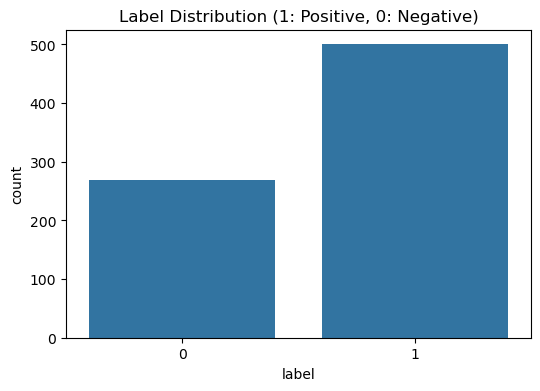

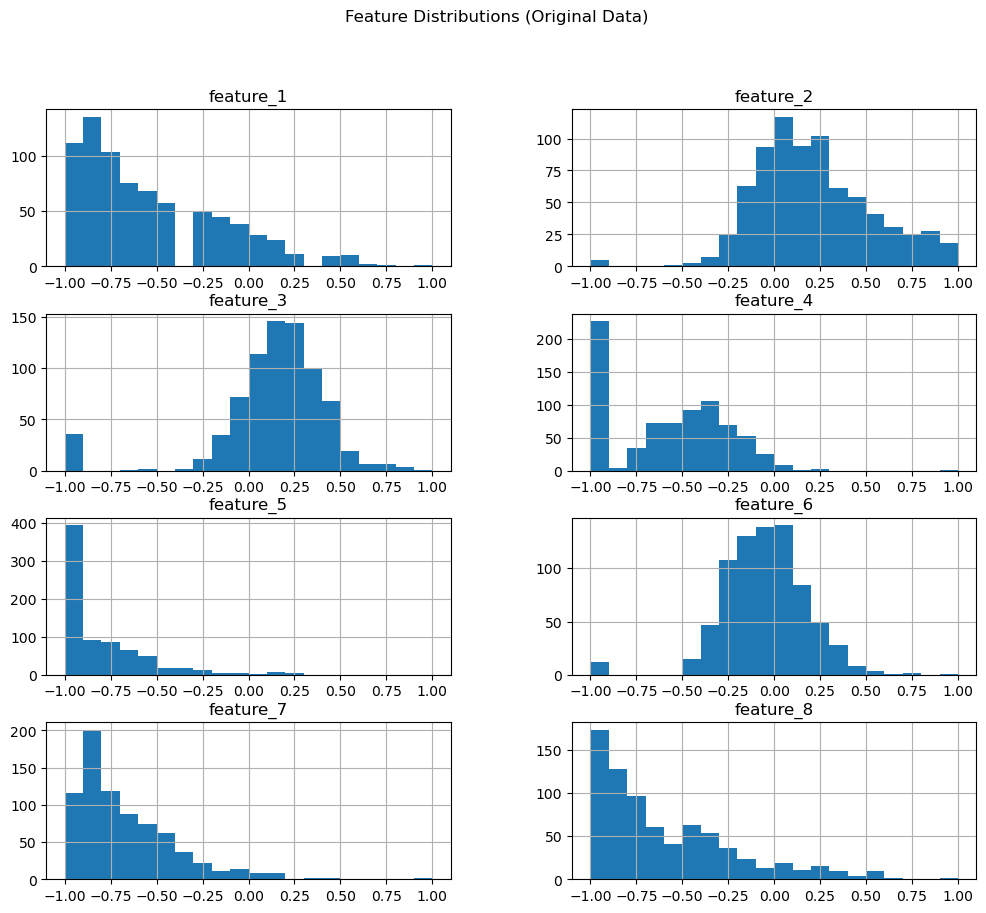

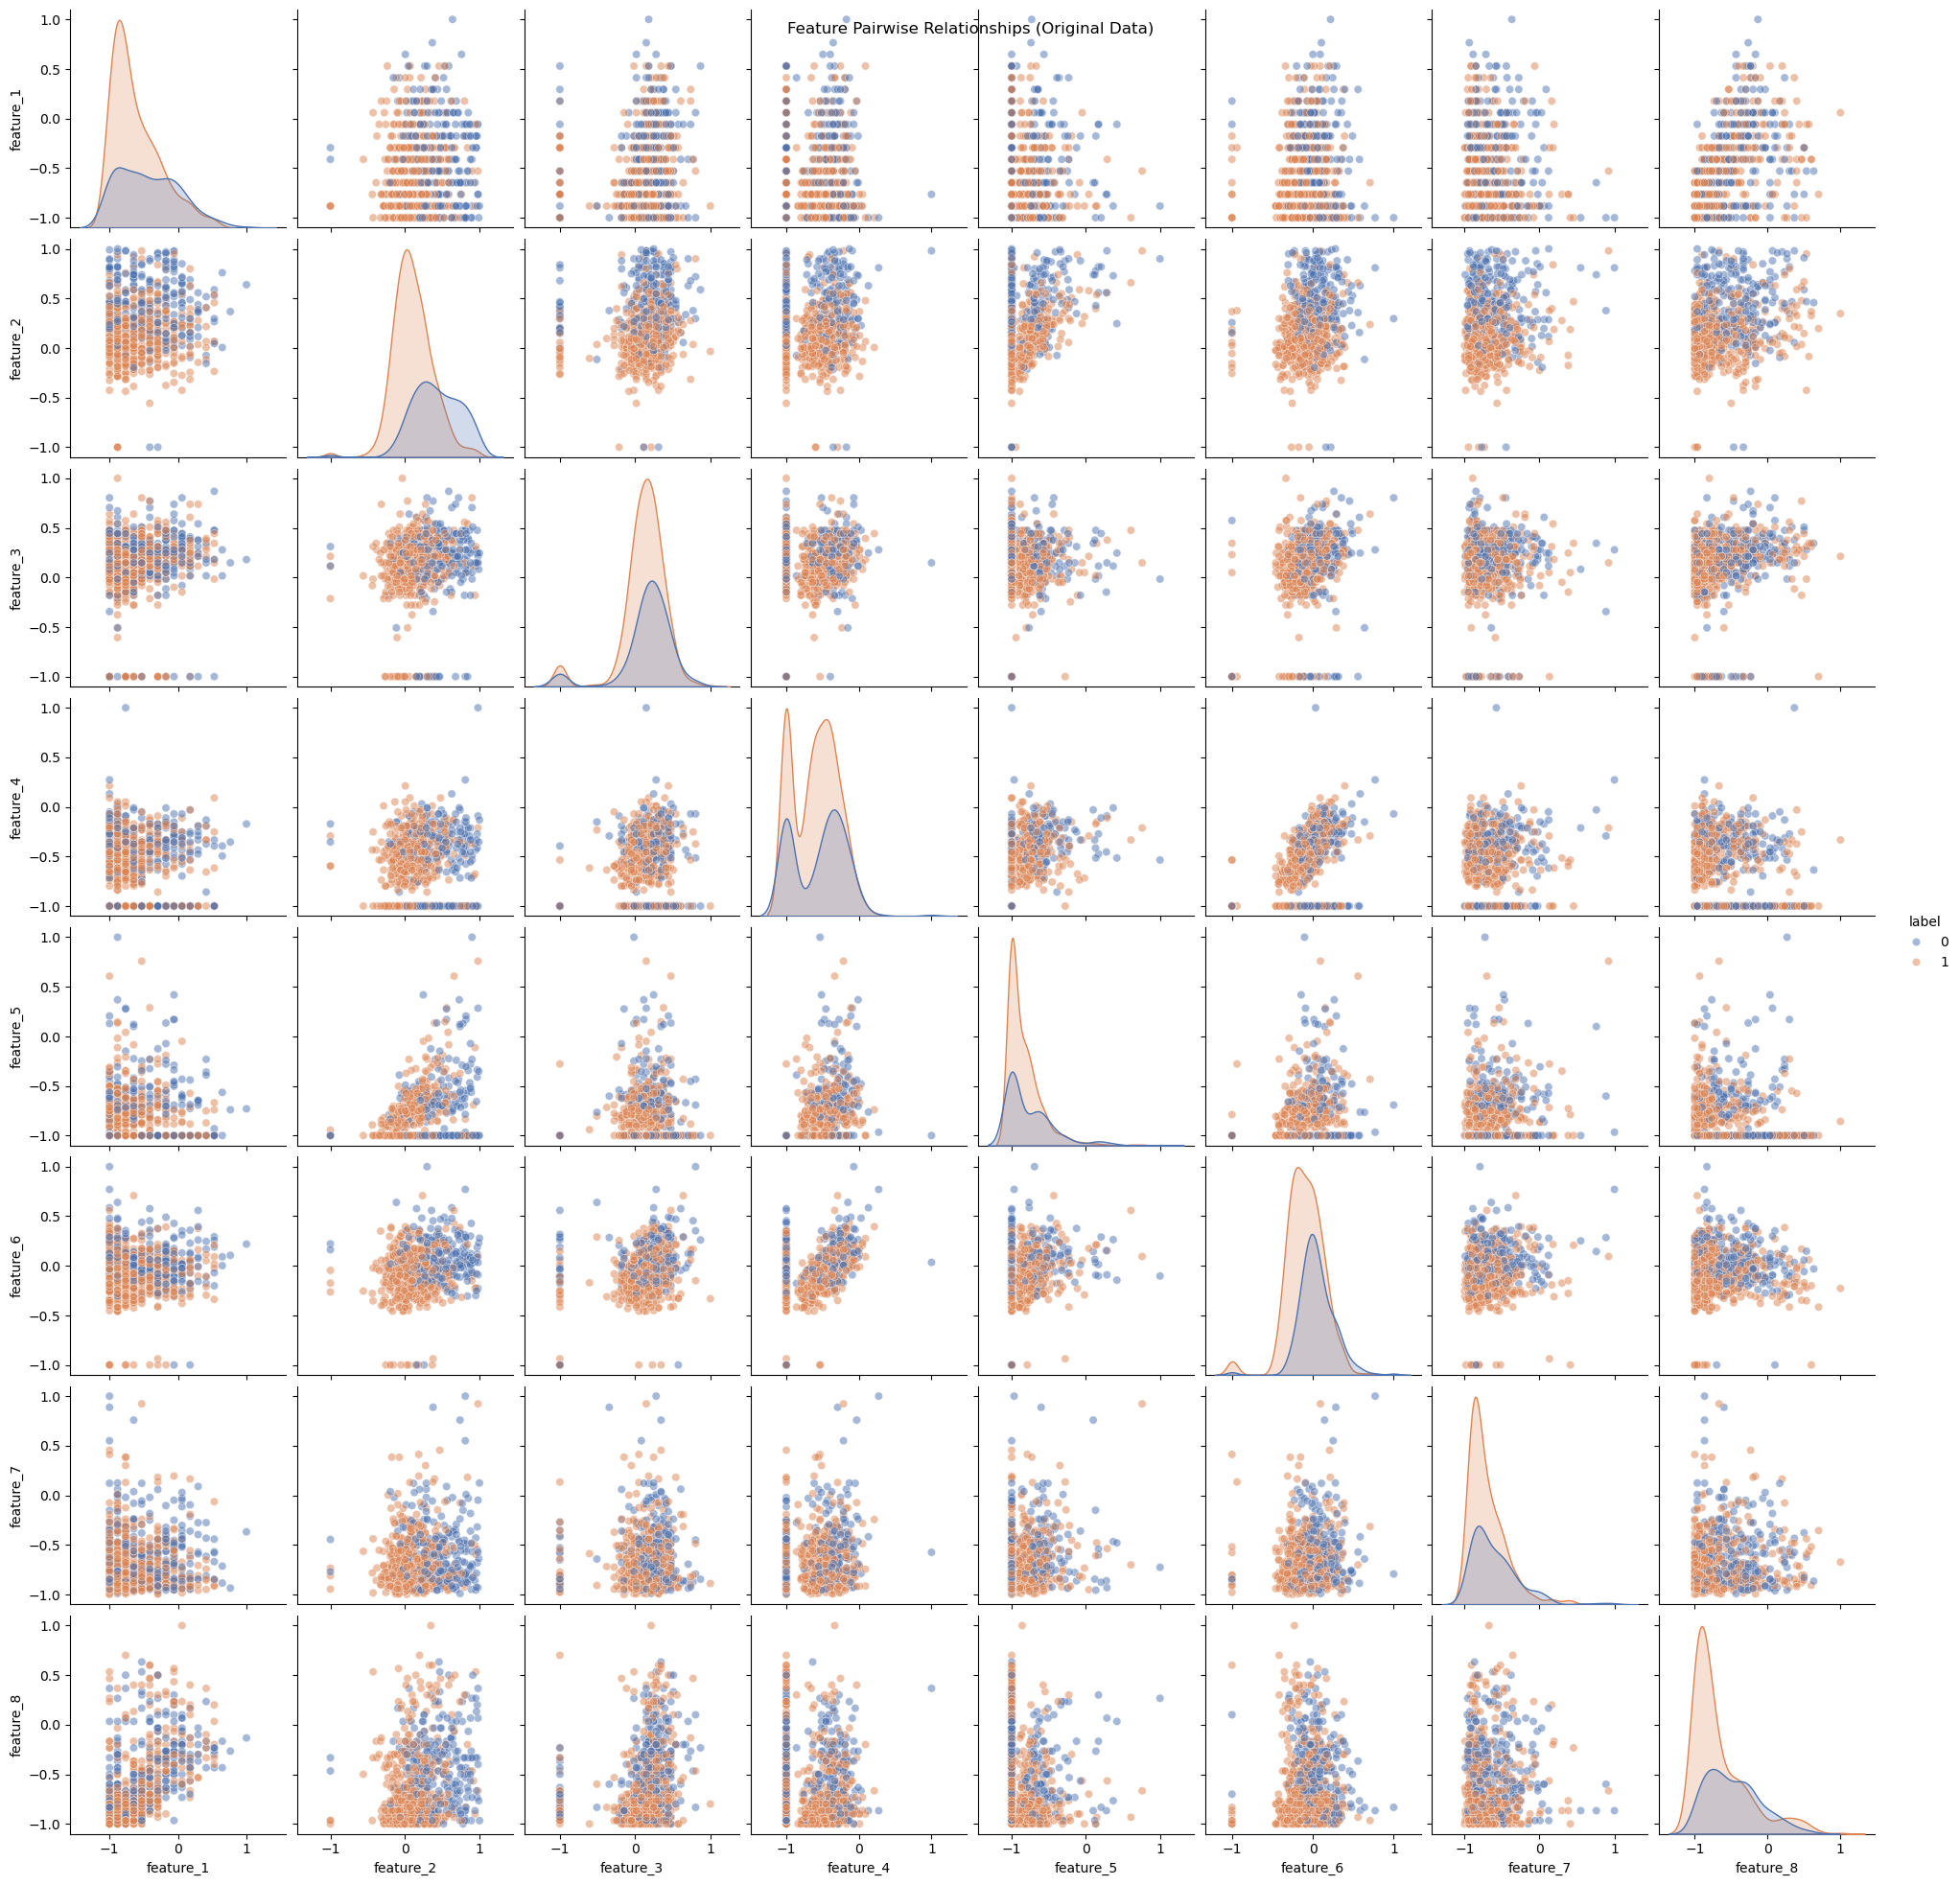

In [3]:
# Convert label -1 to 0
data_df['label'] = data_df['label'].replace({-1: 0})

# Visualization of label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data_df)
plt.title('Label Distribution (1: Positive, 0: Negative)')
plt.show()

# Distribution of each feature (histogram)
data_df.iloc[:, 1:].hist(bins=20, figsize=(12, 10), layout=(4, 2))
plt.suptitle('Feature Distributions (Original Data)')
plt.show()

# Relationships between features (scatter matrix)
sns.pairplot(data_df, hue='label', palette='deep', plot_kws={'alpha': 0.5})
plt.suptitle('Feature Pairwise Relationships (Original Data)')
plt.show()

In [4]:
# Check for missing values and fill with NaN
data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
data_df.fillna(np.nan, inplace=True)

# Handle outliers for each feature
data_df['feature_1'] = data_df['feature_1'].where((data_df['feature_1'] >= -1) & (data_df['feature_1'] <= 0.75), np.nan)

data_df['feature_2'] = data_df['feature_2'].where((data_df['feature_2'] >= -0.75) & (data_df['feature_2'] <= 1), np.nan)

data_df['feature_4'] = data_df['feature_4'].where((data_df['feature_4'] >= -1) & (data_df['feature_4'] <= 0.2), np.nan)

data_df['feature_5'] = data_df['feature_5'].where((data_df['feature_5'] >= -1) & (data_df['feature_5'] <= 0.5), np.nan)

data_df['feature_6'] = data_df['feature_6'].where((data_df['feature_6'] >= -0.5) & (data_df['feature_6'] <= 0.6), np.nan)

data_df['feature_7'] = data_df['feature_7'].where((data_df['feature_7'] >= -1) & (data_df['feature_7'] <= 0.5), np.nan)

data_df['feature_8'] = data_df['feature_8'].where((data_df['feature_8'] >= -1) & (data_df['feature_8'] <= 0.75), np.nan)

print(f"Shape after outlier cleaning: {data_df.shape}")

data_df.isnull().sum()

Shape after outlier cleaning: (768, 9)


label         0
feature_1     2
feature_2     5
feature_3     0
feature_4     3
feature_5     3
feature_6    16
feature_7     5
feature_8    10
dtype: int64

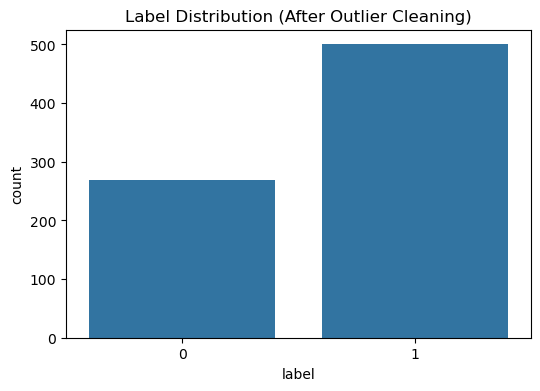

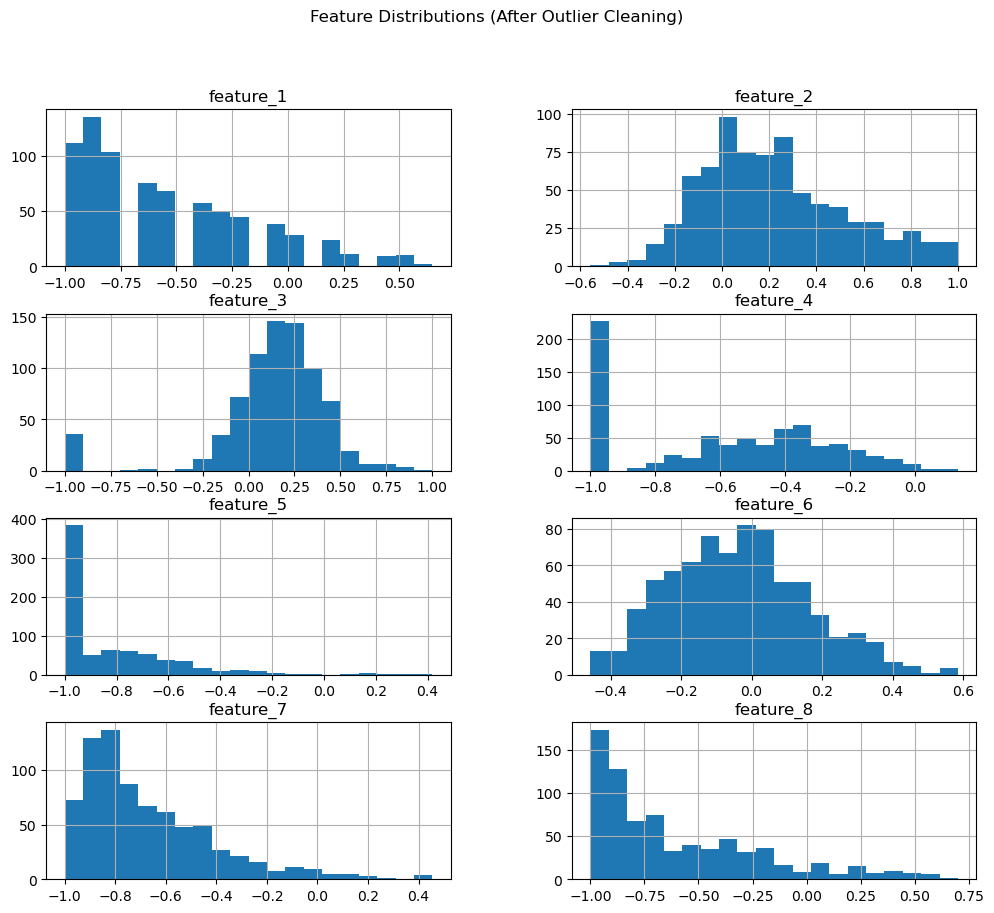

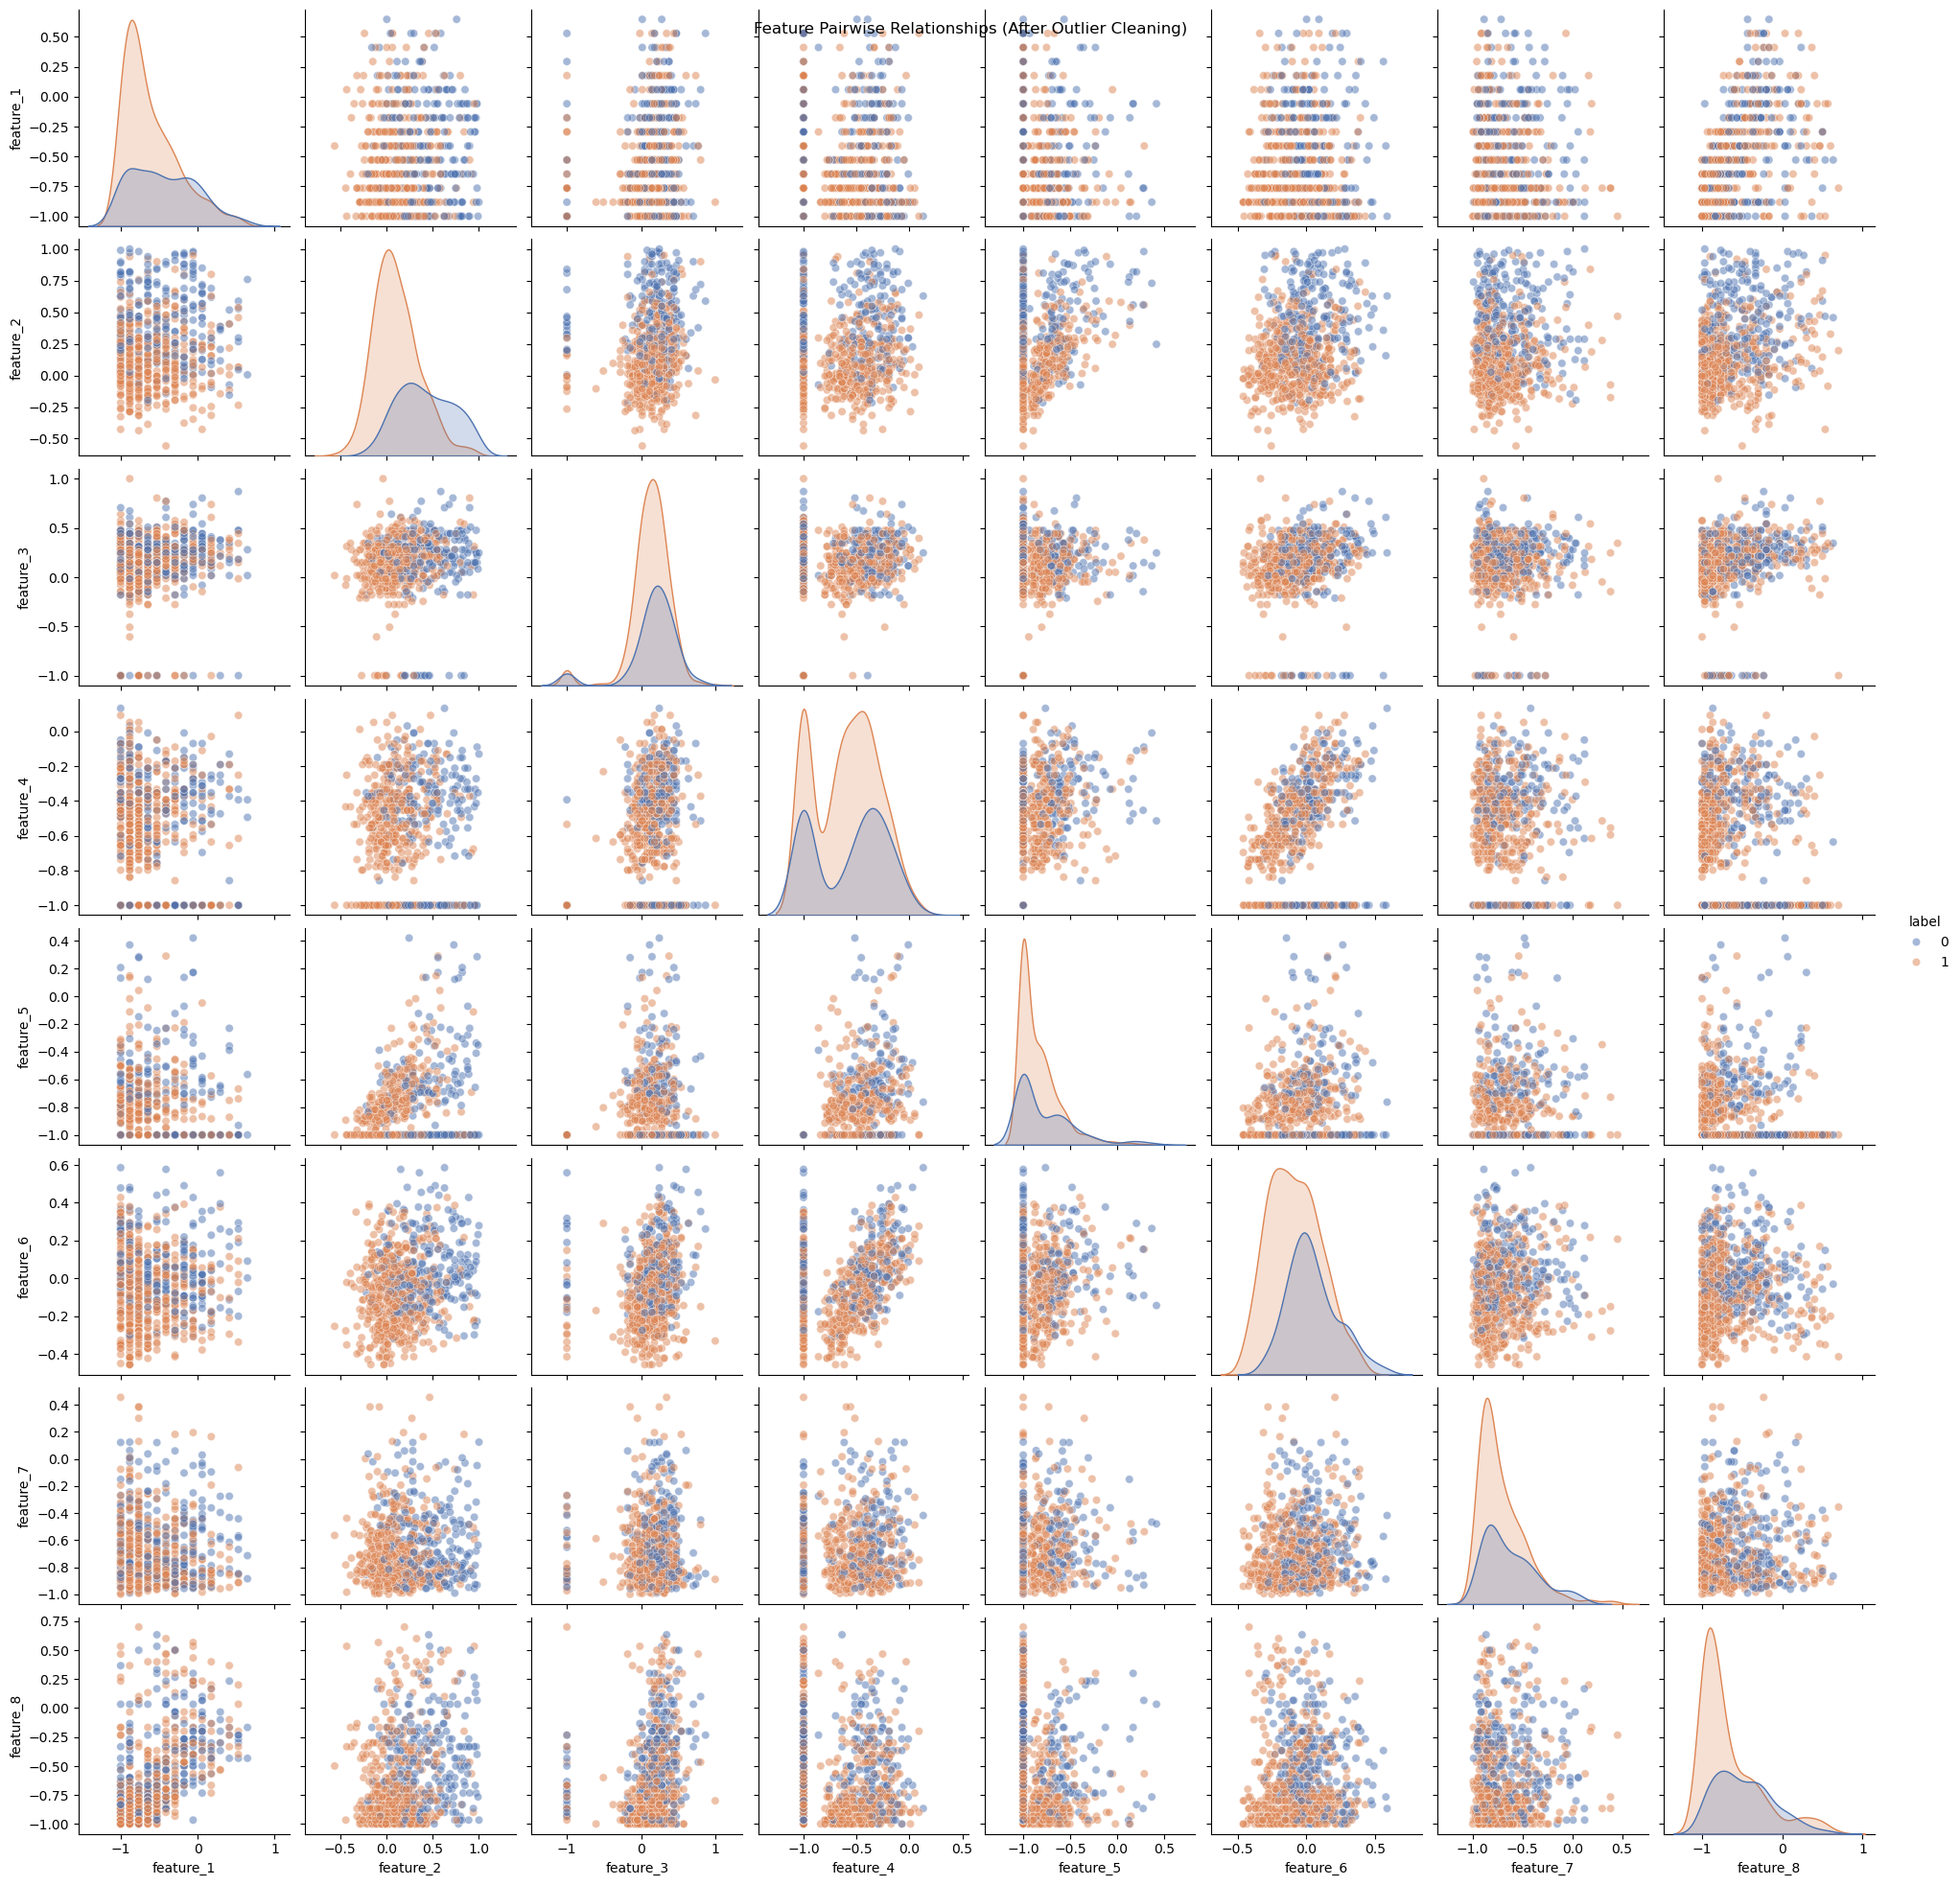

In [5]:
# Data visualization (after processing)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data_df)
plt.title('Label Distribution (After Outlier Cleaning)')
plt.show()

# Feature distribution histogram
data_df.iloc[:, 1:].hist(bins=20, figsize=(12, 10), layout=(4, 2))
plt.suptitle('Feature Distributions (After Outlier Cleaning)')
plt.show()

# Relationships between features (scatter matrix)
sns.pairplot(data_df.dropna(), hue='label', palette='deep', plot_kws={'alpha': 0.5})
plt.suptitle('Feature Pairwise Relationships (After Outlier Cleaning)')
plt.show()

In [6]:
# Fill missing values with the mean of each feature
data_df_filled = data_df.fillna(data_df.mean())

data_df_filled.isnull().sum()

label        0
feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
feature_8    0
dtype: int64

# Part 2 Model Selection and Optimization

In [7]:
# Fix random seed to ensure consistent results
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Split the dataset
X = data_df_filled.iloc[:, 1:].values
y = data_df_filled['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (614, 8)
X_test shape: (154, 8)


## Baseline Model Construction

Accuracy: 0.7532
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65        55
           1       0.81      0.81      0.81        99

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



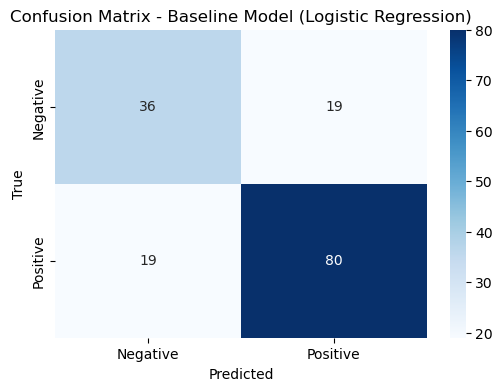

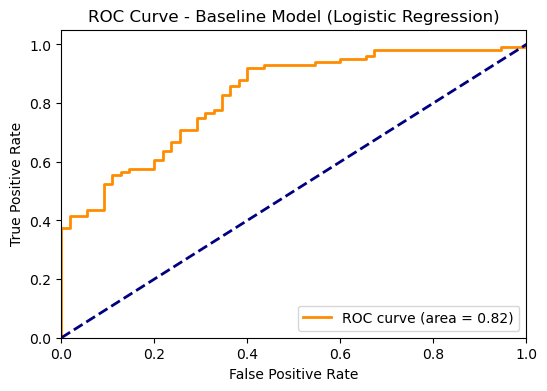

In [8]:
# Baseline model based on Sklearn: Logistic Regression
baseline_model = LogisticRegression(solver='liblinear')  
baseline_model.fit(X_train, y_train)  
y_pred_baseline = baseline_model.predict(X_test)  
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Baseline Model (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate prediction probabilities
y_pred_prob = baseline_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Model (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

## Single-Layer Perceptron Construction

Epoch [100/1000], Loss: 0.8018
Epoch [200/1000], Loss: 0.7801
Epoch [300/1000], Loss: 0.7599
Epoch [400/1000], Loss: 0.7412
Epoch [500/1000], Loss: 0.7240
Epoch [600/1000], Loss: 0.7081
Epoch [700/1000], Loss: 0.6934
Epoch [800/1000], Loss: 0.6799
Epoch [900/1000], Loss: 0.6673
Epoch [1000/1000], Loss: 0.6558
Train Accuracy: 0.6303
Test Accuracy: 0.6299
Classification Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.43      0.11      0.17        55
         1.0       0.65      0.92      0.76        99

    accuracy                           0.63       154
   macro avg       0.54      0.51      0.47       154
weighted avg       0.57      0.63      0.55       154



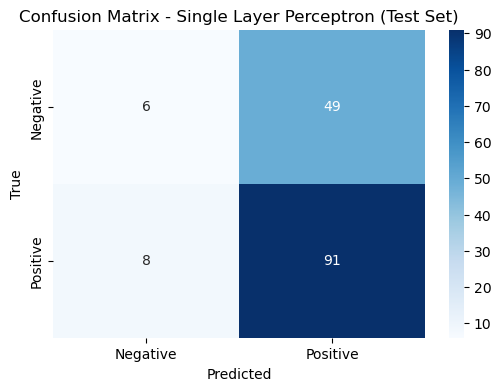

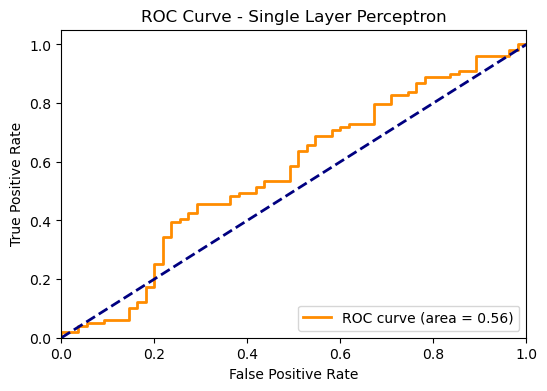

In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Convert to column vector
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

torch.manual_seed(42)

# Define a single-layer perceptron model (without sigmoid activation function)
class LinearPerceptron(nn.Module):
    def __init__(self, input_size):
        super(LinearPerceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Single output node

    def forward(self, x):
        return self.fc(x)  # No activation function

# Initialize the model
input_size = X_train.shape[1]
model = LinearPerceptron(input_size)

# Loss function and optimizer (using BCEWithLogitsLoss)
criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid and BCELoss
optimizer = optim.SGD(model.parameters(), lr=0.001)  # Simple stochastic gradient descent optimizer

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()  # Clear the gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    # Output the loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = (torch.sigmoid(model(X_train_tensor)) > 0.5).float()  # Classify using a threshold of 0.5
    y_pred_test = (torch.sigmoid(model(X_test_tensor)) > 0.5).float()  # Classify using a threshold of 0.5

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train_tensor, y_pred_train)
    test_accuracy = accuracy_score(y_test_tensor, y_pred_test)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report (Test Set):\n", classification_report(y_test_tensor, y_pred_test))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_tensor, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Single Layer Perceptron (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute ROC curve and AUC
y_pred_prob = torch.sigmoid(model(X_test_tensor)).detach().numpy()  # Get probability output
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Single Layer Perceptron')
plt.legend(loc="lower right")
plt.show()

## SLP with Sigmoid Activation Function

Epoch [100/1000], Loss: 0.8018
Epoch [200/1000], Loss: 0.7801
Epoch [300/1000], Loss: 0.7599
Epoch [400/1000], Loss: 0.7412
Epoch [500/1000], Loss: 0.7240
Epoch [600/1000], Loss: 0.7081
Epoch [700/1000], Loss: 0.6934
Epoch [800/1000], Loss: 0.6799
Epoch [900/1000], Loss: 0.6673
Epoch [1000/1000], Loss: 0.6558
Train Accuracy: 0.6303
Test Accuracy: 0.6299
Classification Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.43      0.11      0.17        55
         1.0       0.65      0.92      0.76        99

    accuracy                           0.63       154
   macro avg       0.54      0.51      0.47       154
weighted avg       0.57      0.63      0.55       154



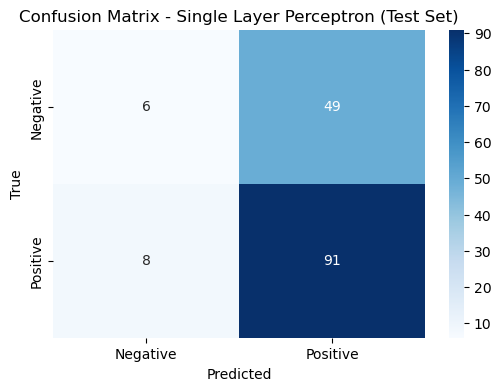

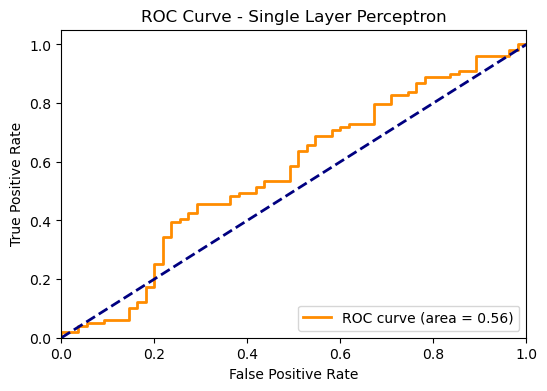

In [10]:
# Define single-layer perceptron model
class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_size):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)  
    
    def forward(self, x):
        x = self.fc(x)
        return torch.sigmoid(x)  

torch.manual_seed(42)
input_size = X_train.shape[1]
model = SingleLayerPerceptron(input_size)

# Loss function and optimizer (using full-batch gradient descent)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)  

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    
    # Full-batch gradient calculation
    optimizer.zero_grad()  
    outputs = model(X_train_tensor) 
    loss = criterion(outputs, y_train_tensor)  
    loss.backward()  
    optimizer.step()  
    
    # Output loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).round()  
    y_pred_test = model(X_test_tensor).round() 

    train_accuracy = accuracy_score(y_train_tensor, y_pred_train)
    test_accuracy = accuracy_score(y_test_tensor, y_pred_test)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

print("Classification Report (Test Set):\n", classification_report(y_test_tensor, y_pred_test))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_tensor, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Single Layer Perceptron (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute ROC curve and AUC
y_pred_prob = model(X_test_tensor).detach().numpy()  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Single Layer Perceptron')
plt.legend(loc="lower right")
plt.show()

## Learning Rate vs Loss Curve

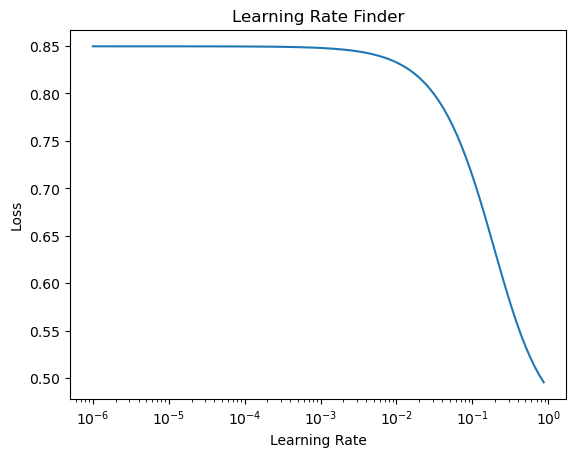

In [11]:
input_size = X_train.shape[1]
model = SingleLayerPerceptron(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6)  

# Learning rate range testing
lrs = []
losses = []
max_lr = 1  
num_steps = 100  
lr_multiplier = (max_lr / 1e-6) ** (1 / num_steps)

for step in range(num_steps):
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    optimizer.param_groups[0]['lr'] *= lr_multiplier

plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()

## Finding the Optimal Learning Rate


Testing with Learning Rate: 0.0085
Epoch [100/1000], Loss: 0.6743
Epoch [200/1000], Loss: 0.5961
Epoch [300/1000], Loss: 0.5539
Epoch [400/1000], Loss: 0.5289
Epoch [500/1000], Loss: 0.5129
Epoch [600/1000], Loss: 0.5020
Epoch [700/1000], Loss: 0.4941
Epoch [800/1000], Loss: 0.4882
Epoch [900/1000], Loss: 0.4836
Epoch [1000/1000], Loss: 0.4801
Learning Rate: 0.0085, Train Accuracy: 0.7752, Test Accuracy: 0.7468, Final Loss: 0.4801

Testing with Learning Rate: 0.01
Epoch [100/1000], Loss: 0.6718
Epoch [200/1000], Loss: 0.5892
Epoch [300/1000], Loss: 0.5471
Epoch [400/1000], Loss: 0.5228
Epoch [500/1000], Loss: 0.5072
Epoch [600/1000], Loss: 0.4967
Epoch [700/1000], Loss: 0.4891
Epoch [800/1000], Loss: 0.4835
Epoch [900/1000], Loss: 0.4793
Epoch [1000/1000], Loss: 0.4761
Learning Rate: 0.01, Train Accuracy: 0.7785, Test Accuracy: 0.7662, Final Loss: 0.4761

Testing with Learning Rate: 0.015
Epoch [100/1000], Loss: 0.6018
Epoch [200/1000], Loss: 0.5449
Epoch [300/1000], Loss: 0.5148
Epoc

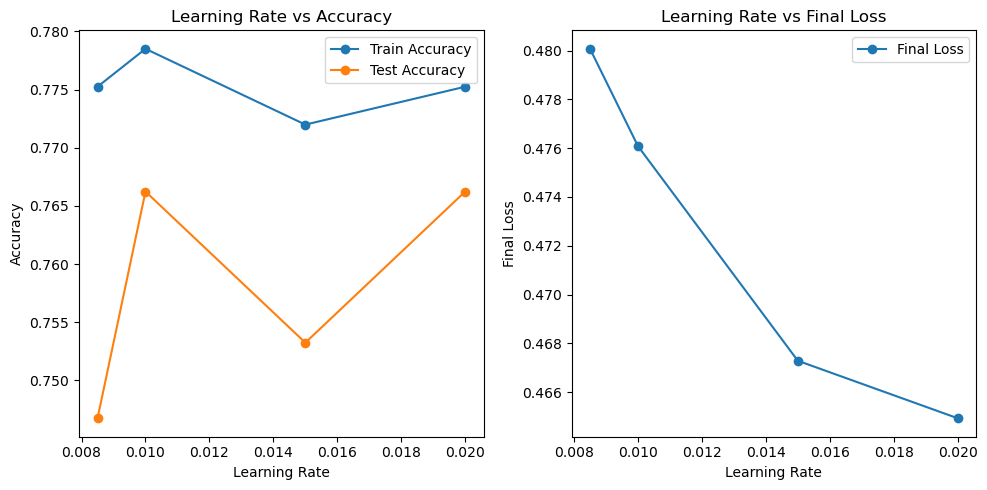

In [12]:
torch.manual_seed(42)
input_size = X_train.shape[1]

learning_rates = [0.0085, 0.01, 0.015, 0.02]

# Train model function
def train_model(lr, num_epochs=1000):
    model = SingleLayerPerceptron(input_size)
    criterion = nn.BCELoss()  
    optimizer = optim.SGD(model.parameters(), lr=lr)  
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()  
        outputs = model(X_train_tensor)  
        loss = criterion(outputs, y_train_tensor)  
        loss.backward()  
        optimizer.step()  
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).round()  
        y_pred_test = model(X_test_tensor).round()  

        train_accuracy = accuracy_score(y_train_tensor, y_pred_train)
        test_accuracy = accuracy_score(y_test_tensor, y_pred_test)
    
    return train_accuracy, test_accuracy, loss.item()

results = []
for lr in learning_rates:
    print(f"\nTesting with Learning Rate: {lr}")
    train_acc, test_acc, final_loss = train_model(lr)
    print(f"Learning Rate: {lr}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Final Loss: {final_loss:.4f}")
    results.append({
        "learning_rate": lr,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "final_loss": final_loss
    })


lrs = [result['learning_rate'] for result in results]
train_accuracies = [result['train_accuracy'] for result in results]
test_accuracies = [result['test_accuracy'] for result in results]
final_losses = [result['final_loss'] for result in results]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lrs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(lrs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Learning Rate vs Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lrs, final_losses, label='Final Loss', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Loss')
plt.title('Learning Rate vs Final Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Finding the Optimal Batch Size


Trying batch size: 32
Epoch [100/1000], Loss: 0.3600
Epoch [200/1000], Loss: 0.1991
Epoch [300/1000], Loss: 0.6214
Epoch [400/1000], Loss: 0.3751
Epoch [500/1000], Loss: 0.3948
Epoch [600/1000], Loss: 0.1274
Epoch [700/1000], Loss: 0.6215
Epoch [800/1000], Loss: 0.2027
Epoch [900/1000], Loss: 0.1069
Epoch [1000/1000], Loss: 0.1107
Train Accuracy: 0.7769
Test Accuracy: 0.7597

Trying batch size: 64
Epoch [100/1000], Loss: 0.5424
Epoch [200/1000], Loss: 0.4924
Epoch [300/1000], Loss: 0.5409
Epoch [400/1000], Loss: 0.3314
Epoch [500/1000], Loss: 0.4398
Epoch [600/1000], Loss: 0.3767
Epoch [700/1000], Loss: 0.5268
Epoch [800/1000], Loss: 0.5183
Epoch [900/1000], Loss: 0.3601
Epoch [1000/1000], Loss: 0.5780
Train Accuracy: 0.7752
Test Accuracy: 0.7532

Trying batch size: 128
Epoch [100/1000], Loss: 0.5229
Epoch [200/1000], Loss: 0.4246
Epoch [300/1000], Loss: 0.4366
Epoch [400/1000], Loss: 0.4110
Epoch [500/1000], Loss: 0.4391
Epoch [600/1000], Loss: 0.5101
Epoch [700/1000], Loss: 0.4326
E

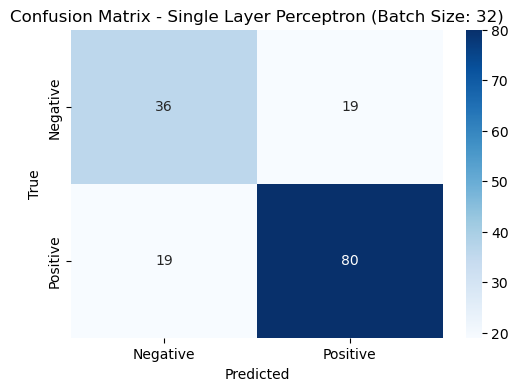

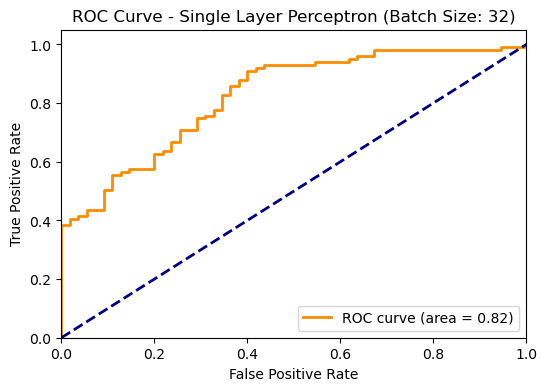

In [13]:
torch.manual_seed(42)
batch_sizes = [32, 64, 128, 256] 
best_lr = 0.02  
results = []

for batch_size in batch_sizes:
    print(f"\nTrying batch size: {batch_size}")
    
    input_size = X_train.shape[1]
    model = SingleLayerPerceptron(input_size)

    criterion = nn.BCELoss()  
    optimizer = optim.SGD(model.parameters(), lr=best_lr)

    # Create DataLoader for batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()

        for batch_data, batch_labels in train_loader:
            # Compute gradients for each mini-batch
            optimizer.zero_grad()  
            outputs = model(batch_data)  
            loss = criterion(outputs, batch_labels)  
            loss.backward()  
            optimizer.step()  

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).round()  
        y_pred_test = model(X_test_tensor).round()  

        train_accuracy = accuracy_score(y_train_tensor, y_pred_train)
        test_accuracy = accuracy_score(y_test_tensor, y_pred_test)

        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Save the results
        results.append({
            'batch_size': batch_size,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        })

best_result = max(results, key=lambda x: x['test_accuracy'])
print(f"\nBest Batch Size: {best_result['batch_size']}, Train Accuracy: {best_result['train_accuracy']:.4f}, Test Accuracy: {best_result['test_accuracy']:.4f}")

print("\nClassification Report for Best Batch Size (Test Set):")
print(classification_report(y_test_tensor, y_pred_test))

conf_matrix = confusion_matrix(y_test_tensor, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - Single Layer Perceptron (Batch Size: {best_result["batch_size"]})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_pred_prob = model(X_test_tensor).detach().numpy()  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Single Layer Perceptron (Batch Size: {best_result["batch_size"]})')
plt.legend(loc="lower right")
plt.show()

## Adding Early Stopping Mechanism

Early stopping triggered at epoch 50
Train Accuracy: 0.7752
Test Accuracy: 0.7597
Classification Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.67      0.65      0.66        55
         1.0       0.81      0.82      0.81        99

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



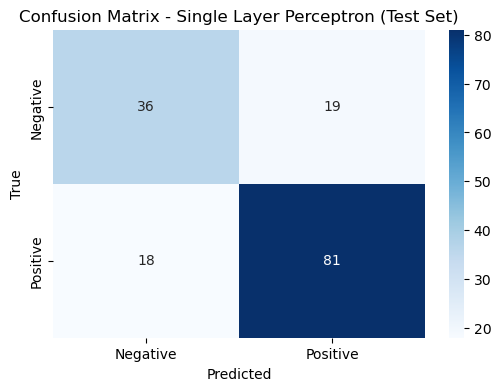

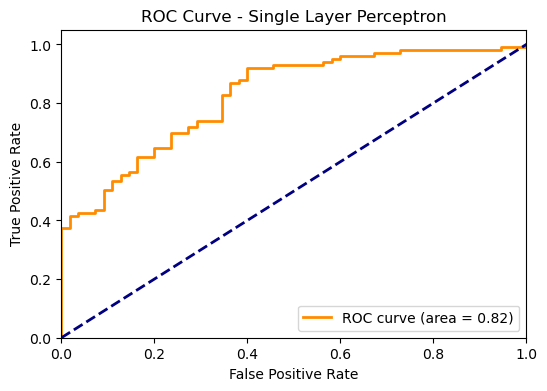

In [14]:
torch.manual_seed(42)
best_lr = 0.02
best_batch_size = 32
num_epochs = 1000
patience = 10 

# Create dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

# Initialize the model
input_size = X_train_tensor.shape[1]
model = SingleLayerPerceptron(input_size)

# Loss function and optimizer
criterion = nn.BCELoss() 
optimizer = optim.SGD(model.parameters(), lr=best_lr)

# Early stopping variables
best_val_loss = float('inf')  # Initialize best validation loss as infinity
early_stop_count = 0  # Count epochs without improvement

train_losses = []
val_losses = []

# Train the model
for epoch in range(num_epochs):
    model.train()

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()  
        outputs = model(batch_data)  
        loss = criterion(outputs, batch_labels)  
        loss.backward()  
        optimizer.step() 

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    # Check early stopping condition
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        early_stop_count = 0  
    else:
        early_stop_count += 1  

    # Trigger early stopping
    if early_stop_count >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).round() 
    y_pred_test = model(X_test_tensor).round()  

    train_accuracy = accuracy_score(y_train_tensor, y_pred_train)
    test_accuracy = accuracy_score(y_test_tensor, y_pred_test)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

print("Classification Report (Test Set):\n", classification_report(y_test_tensor, y_pred_test))

conf_matrix = confusion_matrix(y_test_tensor, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - Single Layer Perceptron (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_pred_prob = model(X_test_tensor).detach().numpy()  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Single Layer Perceptron')
plt.legend(loc="lower right")
plt.show()

## Five-Fold Cross-Validation


Training fold 1/5...
Early stopping triggered at epoch 79
Fold 1: Train Accuracy = 0.7821, Validation Accuracy = 0.7886

Training fold 2/5...
Early stopping triggered at epoch 48
Fold 2: Train Accuracy = 0.7739, Validation Accuracy = 0.7805

Training fold 3/5...
Early stopping triggered at epoch 38
Fold 3: Train Accuracy = 0.7943, Validation Accuracy = 0.7398

Training fold 4/5...
Early stopping triggered at epoch 93
Fold 4: Train Accuracy = 0.7800, Validation Accuracy = 0.7642

Training fold 5/5...
Early stopping triggered at epoch 64
Fold 5: Train Accuracy = 0.7825, Validation Accuracy = 0.7623

Mean Train Accuracy across 5 folds: 0.7826
Mean Validation Accuracy across 5 folds: 0.7671


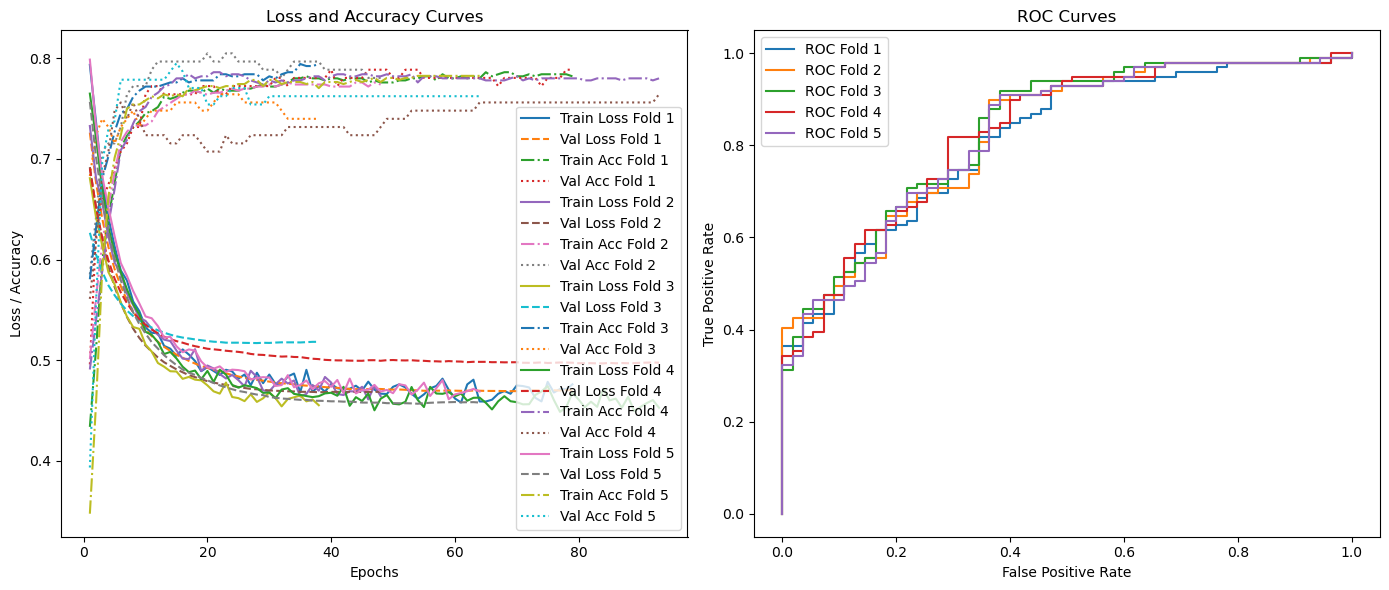

In [15]:
torch.manual_seed(42)
best_lr = 0.02
best_batch_size = 32
num_epochs = 1000
patience = 10  
k_folds = 5  
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

# Initialize history lists
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Store ROC values for each fold
roc_values = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_tensor)):
    print(f"\nTraining fold {fold+1}/{k_folds}...")

    # Initialize the model, reinitialize for each fold
    input_size = X_train_tensor.shape[1]
    model = SingleLayerPerceptron(input_size)

    # Loss function and optimizer
    criterion = nn.BCELoss()  
    optimizer = optim.SGD(model.parameters(), lr=best_lr)

    # Create datasets and data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_subset = Subset(train_dataset, train_idx)  
    val_subset = Subset(train_dataset, val_idx)      

    train_loader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=best_batch_size)

    # Early stopping variables
    best_val_loss = float('inf')  
    early_stop_count = 0  
    
    # Store training and validation loss/accuracy for each fold
    fold_train_loss = []
    fold_val_loss = []
    fold_train_acc = []
    fold_val_acc = []
    
    # Train the model
    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.round()
            correct_train += (predicted == batch_labels).sum().item()
            total_train += batch_labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        fold_train_loss.append(avg_train_loss)

        train_accuracy = correct_train / total_train
        fold_train_acc.append(train_accuracy)

        # Validation evaluation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                val_outputs = model(batch_data)
                val_loss += criterion(val_outputs, batch_labels).item()  
                predicted = val_outputs.round()
                correct_val += (predicted == batch_labels).sum().item()
                total_val += batch_labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        fold_val_loss.append(avg_val_loss)

        val_accuracy = correct_val / total_val
        fold_val_acc.append(val_accuracy)

        if (epoch+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_count = 0  
        else:
            early_stop_count += 1  

        if early_stop_count >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Fold {fold+1}: Train Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")
    
    # Record train and validation accuracy for each fold
    fold_results.append({
        'fold': fold + 1,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'epoch': epoch + 1
    })

    # Store loss and accuracy for each fold
    train_loss_history.append(fold_train_loss)
    val_loss_history.append(fold_val_loss)
    train_acc_history.append(fold_train_acc)
    val_acc_history.append(fold_val_acc)

    fpr, tpr, _ = roc_curve(y_test_tensor, model(X_test_tensor).detach().numpy())
    roc_values.append((fpr, tpr))

mean_train_accuracy = sum([result['train_accuracy'] for result in fold_results]) / k_folds
mean_val_accuracy = sum([result['val_accuracy'] for result in fold_results]) / k_folds

print(f"\nMean Train Accuracy across {k_folds} folds: {mean_train_accuracy:.4f}")
print(f"Mean Validation Accuracy across {k_folds} folds: {mean_val_accuracy:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i in range(k_folds):
    plt.plot(range(1, len(train_loss_history[i])+1), train_loss_history[i], linestyle='-', label=f'Train Loss Fold {i+1}')
    plt.plot(range(1, len(val_loss_history[i])+1), val_loss_history[i], linestyle='--', label=f'Val Loss Fold {i+1}')
    plt.plot(range(1, len(train_acc_history[i])+1), train_acc_history[i], linestyle='-.', label=f'Train Acc Fold {i+1}')
    plt.plot(range(1, len(val_acc_history[i])+1), val_acc_history[i], linestyle=':', label=f'Val Acc Fold {i+1}')
    
plt.title('Loss and Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend(loc="best")

plt.subplot(1, 2, 2)
for i in range(k_folds):
    fpr, tpr = roc_values[i]
    plt.plot(fpr, tpr, label=f'ROC Fold {i+1}')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

## Model Comparison

In [16]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline) 
perceptron_test_accuracy = test_accuracy 

if perceptron_test_accuracy > baseline_accuracy:
    best_model = "Single Layer Perceptron"
else:
    best_model = "Baseline Logistic Regression"

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
print(f"Single Layer Perceptron Test Accuracy: {perceptron_test_accuracy:.4f}")
print(f"The best performing model is: {best_model}")

Baseline Model Accuracy: 0.7532
Single Layer Perceptron Test Accuracy: 0.7597
The best performing model is: Single Layer Perceptron
